# Exercises:

- Load the file macro_predictors from the tidy_finance_*.sqlitedatabase. 
Create a variable ythat contains the market excess returns from the Goyal-Welsh dataset (rp_div) and a matrix X that contains the remaining macroeconomic variables except for the column month. 
You will use X and y to perform penalized regressions. Try to run a simple linear regression of X on 'y' to analyze the relationship between the macroeconomic variables and market returns. 
Which problems do you encounter?
- Write a function that requires three inputs, y (a $T$ vector), X (a $T\times K$ matrix), and lambda and which returns the **Ridge** estimator (a  $K$ vector) for given penalization parameter $\lambda$. Recall that the intercept should not be penalized. Therefore, your function should allow you to indicate whether $X$ contains a vector of ones as the first column which should be exempt from the $L_2$ penalty.
- Compute the $L_2$ norm ($\beta' \beta$) for the regression coefficients based on the predictive regression from the previous exercise for a range of $\lambda$’s and illustrate the effect of the penalization in a suitable figure.
- Now, write a function that requires three inputs, y (a $T$ vector), X (a $T\times K$ matrix), and lambda and which returns the **Lasso** estimator (a $K$ vector) for given penalization parameter . Recall that the intercept should not be penalized. Therefore, your function should allow you to indicate whether  contains a vector of ones as the first column which should be exempt from the $L_1$ penalty.
- After you are sure you understand what Ridge and Lasso regression are doing, familiarize yourself with the documentation of the package glmnet(). It is a thoroughly tested and well-established package that provides efficient code to compute the penalized regression coefficients not only for Ridge and Lasso but also for combinations, therefore, commonly called elastic nets.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
# optimization tools
from scipy import optimize
# Plotting tools
from plotnine import *
from mizani.formatters import percent_format, number_bytes_format
from sklearn.linear_model import Lasso


path_to_db = r'/Users/asbjornfyhn/Desktop/Emp Fin/data'

## Part 1
*Load the file macro_predictors from the tidy_finance_r.sqlitedatabase. 
Create a variable ythat contains the market excess returns from the Goyal-Welsh dataset (rp_div) and a matrix X that contains the remaining macroeconomic variables except for the column month. 
You will use X and y to perform penalized regressions. Try to run a simple linear regression of X on 'y' to analyze the relationship between the macroeconomic variables and market returns. 
Which problems do you encounter?*

In [3]:
# notice that we use tidy_finance_r.sqlite rather than the python version due to the latter not having the column rp_div
tidy_finance_r = sqlite3.connect( database=f"{path_to_db}/tidy_finance_r.sqlite",)

# read the table macro_predictors from the database
macro_pred = pd.read_sql('select * from macro_predictors;',con=tidy_finance_r,parse_dates='month')

# create the dependent and independent variables
y = macro_pred['rp_div'].values
x = macro_pred[[col for col in macro_pred.columns if col not in ['rp_div','month']]].values

# OLS for Welsh data fails because X is not of full rank
[x.shape[1], np.linalg.matrix_rank(x)]


[13, 11]

## Part 2
*Write a function that requires three inputs, y (a $T$ vector), X (a $T\times K$ matrix), and lambda and which returns the **Ridge** estimator (a  $K$ vector) for given penalization parameter $\lambda$. Recall that the intercept should not be penalized. Therefore, your function should allow you to indicate whether $X$ contains a vector of ones as the first column which should be exempt from the $L_2$ penalty.*

In [4]:
def ridge_estimator(
        y:np.array,
        X:np.array,
        lambda_:float,
        exempt_intercept:bool = False
        ) -> np.array:
    """
    This function takes three inputs, a vector, y, a  matrix, X, and a penalization parameter lambda_ and returns the Ridge estimator. 
    The intercept should not be penalized. 
    Therefore, the function allows you to indicate whether the matrix X contains a vector of ones as the first column 
        which should be exempt from the L2 penalty.
    """
    # number of variables
    p = X.shape[1]
    # matrix A which has 1 on the diagonal and 0 elsewhere
    A = np.eye(p)
    if exempt_intercept:
        A[0, :] = 0
    # calculate the Ridge estimator
    beta = np.linalg.inv(X.T @ X + lambda_ * A) @ X.T @ y
    return beta

## Part 3
*Compute the $L_2$ norm ($\beta' \beta$) for the regression coefficients based on the predictive regression from the previous exercise for a range of $\lambda$’s and illustrate the effect of the penalization in a suitable figure.*

In [5]:
# create a range of lambda values
lambda_values = np.linspace(0.01, 100, 1000)

# create an empty list to store the L2 norm
l2_norm = []

# loop over the lambda values
for lambda_ in lambda_values:
    # calculate the Ridge estimator
    beta = ridge_estimator(y, x, lambda_)
    # calculate the L2 norm
    l2_norm.append(beta.T @ beta)

# create a data frame
l2_norm_df = pd.DataFrame({'lambda':lambda_values, 'l2_norm':l2_norm})

# print head
print(l2_norm_df.head())

    lambda   l2_norm
0  0.01000  0.253682
1  0.11009  0.037656
2  0.21018  0.025036
3  0.31027  0.018828
4  0.41036  0.014902


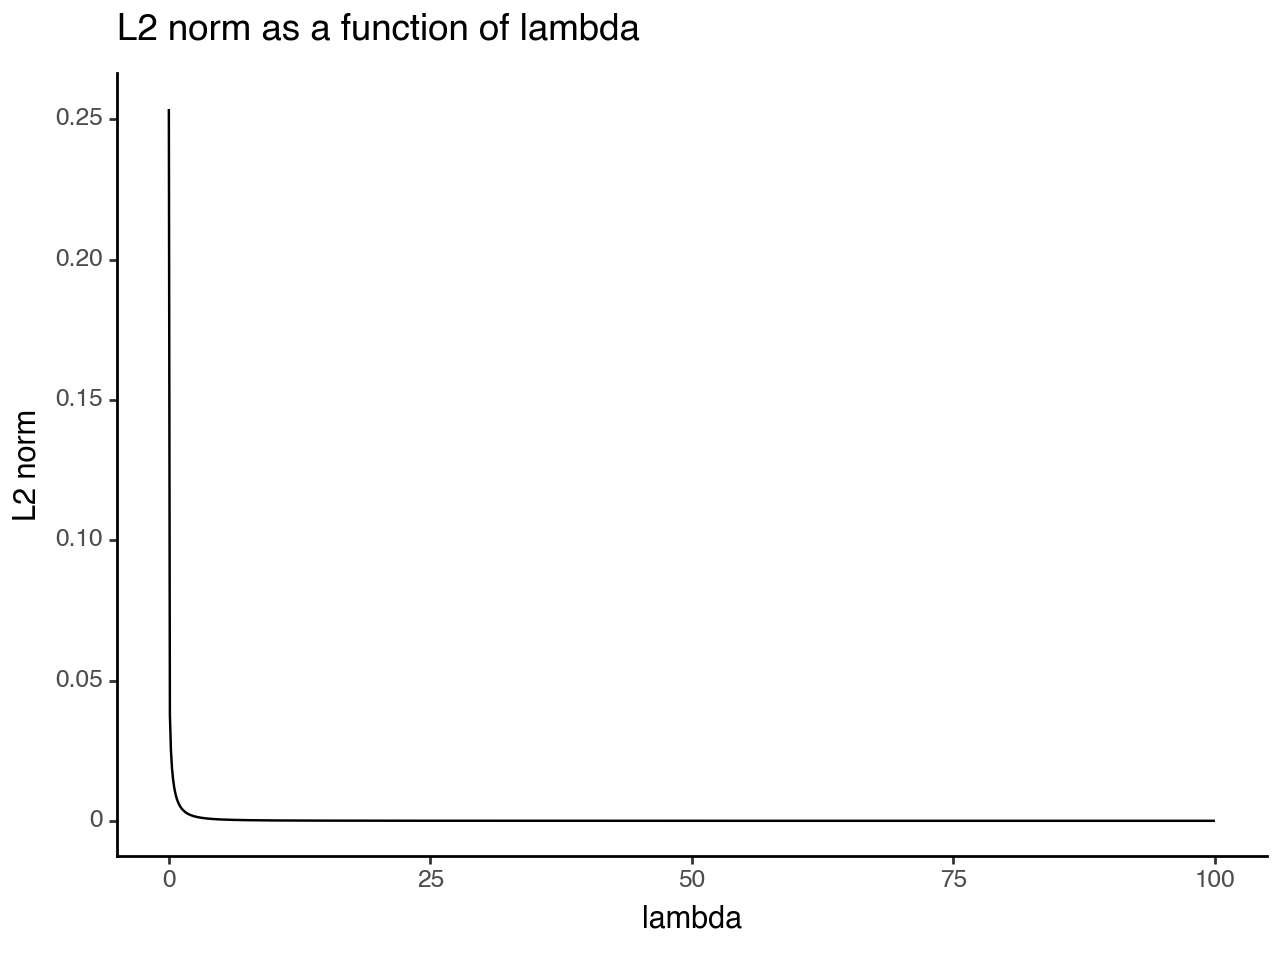

<Figure Size: (640 x 480)>

In [6]:
# plot the L2 norm as a function of lambda
(
    ggplot(l2_norm_df, aes(x='lambda', y='l2_norm')) 
    + geom_line()
    + labs(title='L2 norm as a function of lambda', x='lambda', y='L2 norm')
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + theme_classic()
)

## Part 4
*Now, write a function that requires three inputs, y (a $T$ vector), X (a $T\times K$ matrix), and lambda and which returns the **Lasso** estimator (a $K$ vector) for given penalization parameter . Recall that the intercept should not be penalized. Therefore, your function should allow you to indicate whether  contains a vector of ones as the first column which should be exempt from the $L_1$ penalty.*

In [13]:
def lasso_estimatator(x,y,lambda_:float=0.01,intercept:bool=False,print_conv_mess:bool=True):
    """
    This function calculates the Lasso estimator
    """
    # define the objective function that sould be minimized
    if intercept: 
        objective_func = lambda beta: np.sum((y - x @ beta)**2) + lambda_ * np.sum(np.abs(beta[1:]))
    else: 
        objective_func = lambda beta: np.sum((y - x @ beta)**2) + lambda_ * np.sum(np.abs(beta))

    # initialize the beta values
    beta_init = np.repeat(0, x.shape[1])

    # optimize the objective function
    res = optimize.fmin(
        func=objective_func, # function to minimize
        x0=beta_init,  # initial values
        # xtol=1e-4,  # tolerance for termination
        # ftol=1e-4, # tolerance for termination
        maxiter=1e4, # maximum number of iterations
        full_output=0, # return only the optimal values
        disp=print_conv_mess   # print convergence messages
    )
    return res

In [14]:
r_ = lasso_estimatator(x,y,0.1,intercept=False)
r_ = np.append(np.nan, r_)

x_w_intercept = np.column_stack((np.repeat(1, x.shape[0]), x))
r_i = lasso_estimatator(x_w_intercept,y,0.1,intercept=True)

pd.DataFrame({'lasso':r_, 'lasso_intercept':r_i}).head(len(r_))

Optimization terminated successfully.
         Current function value: 1.344505
         Iterations: 1317
         Function evaluations: 1826
Optimization terminated successfully.
         Current function value: 1.345420
         Iterations: 329
         Function evaluations: 458


,lasso,lasso_intercept
0,NaN,1.207911e-03
1,-1.325627e-07,-5.185037e-04
2,1.682817e-03,1.198069e-05
3,-3.039232e-03,-3.078096e-04
4,-1.492522e-04,2.154116e-03
5,-1.014300e-03,-7.321368e-06
6,1.746333e-04,-3.664529e-04
7,-1.280559e-03,3.597954e-06
8,-1.726477e-02,-2.447423e-03
9,-3.659171e-03,-4.610738e-05


In [25]:
# initialize the lambda values
lambda_values = np.linspace(0.00, 0.5, 20)

# initialize a list of L1 norms
l1_norm = []
l1_norm_sklearn = []

# loop over the lambda values
for lambda_ in lambda_values:
    # calculate the Lasso estimator
    beta = lasso_estimatator(x, y, lambda_, intercept=False,print_conv_mess=False)
    beta_sklearn = Lasso(alpha=lambda_, fit_intercept=False).fit(x, y).coef_
    # calculate the L1 norm
    l1_norm.append(np.sum(np.abs(beta)))
    l1_norm_sklearn.append(np.sum(np.abs(beta_sklearn)))

# create a data frame
l1_norm_df = pd.DataFrame({'lambda':lambda_values, 'l1_norm':l1_norm, 'l1_norm_sklearn':l1_norm_sklearn})
l1_norm_df = l1_norm_df.set_index('lambda').stack().reset_index().rename(columns={'level_1':'method', 0:'l1_norm'})

# print head
print(l1_norm_df.head())


/opt/anaconda3/envs/aef/lib/python3.10/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/anaconda3/envs/aef/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
/opt/anaconda3/envs/aef/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.558e-01, tolerance: 1.349e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


     lambda           method   l1_norm
0  0.000000          l1_norm  0.961012
1  0.000000  l1_norm_sklearn  2.079689
2  0.026316          l1_norm  0.294454
3  0.026316  l1_norm_sklearn  0.000000
4  0.052632          l1_norm  0.176024


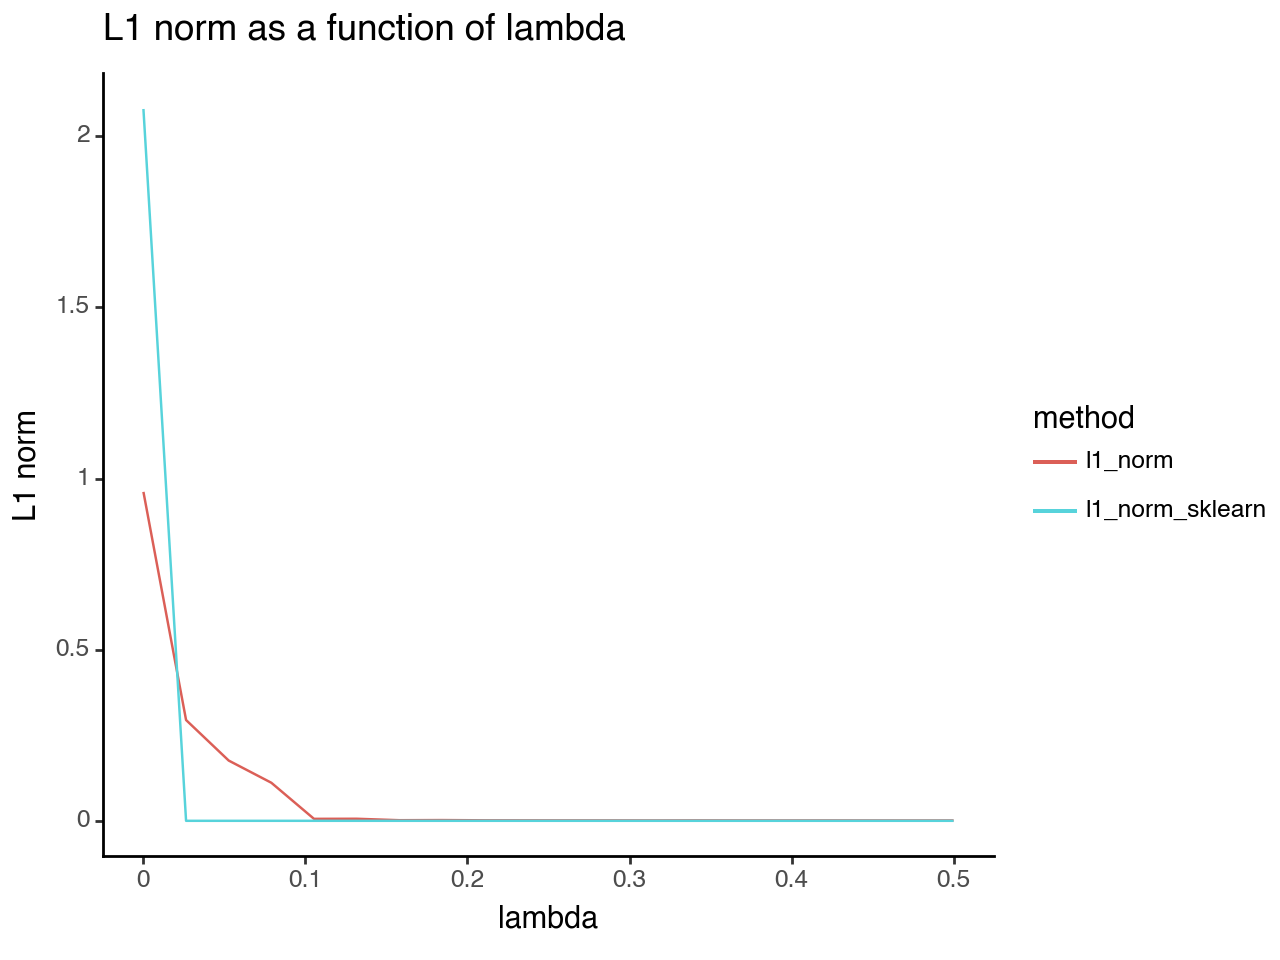

<Figure Size: (640 x 480)>

In [26]:
# plot 
(
    ggplot(l1_norm_df, aes(x='lambda', y='l1_norm', color='method')) 
    + geom_line()
    + labs(title='L1 norm as a function of lambda', x='lambda', y='L1 norm')
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + theme_classic()
)